In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy import stats

from one.api import ONE
from brainbox.io.one import SessionLoader

from iblnm.config import *
from iblnm.util import protocol2type, _load_event_times
from iblnm.resp import get_responses

from iblphotometry import fpio, metrics

## Pick a sessions by querying Alyx
(See below for selecting sessions using df_session from a previous query)

In [2]:
one = ONE()

In [3]:
# Pick a subject
subject = 'ZFM-08871'

df_sessions = pd.DataFrame(one.alyx.rest('sessions', 'list', project='ibl_fibrephotometry', subject=subject, datasets='photometry.signal.pqt')).rename(columns={'id':'eid'})
df_sessions.head()

,eid,subject,start_time,number,lab,projects,url,task_protocol
0,f2343157-4824-4fa2-84c1-a8bfebe21a8f,ZFM-08871,2025-10-01T11:52:18.529615,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_biasedChoiceWorld8.29.0
1,798aa025-8924-43cb-b632-9080781ff5f9,ZFM-08871,2025-09-29T13:48:05.143312,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_biasedChoiceWorld8.29.0
2,fa2a43e1-769f-4d24-aede-e491d2036833,ZFM-08871,2025-09-26T10:54:34.387145,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_biasedChoiceWorld8.29.0
3,8dd80bc5-8e73-4fe3-98b0-a7657e60e33b,ZFM-08871,2025-09-25T12:56:34.367113,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_biasedChoiceWorld8.29.0
4,83c8d81d-0837-40a4-a7e0-895928ab5ef8,ZFM-08871,2025-09-24T12:12:15.743458,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_biasedChoiceWorld8.29.0


In [4]:
# df_sessions['start_time_dt'] = df_sessions['start_time'].apply(datetime.fromisoformat)
# df_sessions['date'] = df_sessions['start_time_dt'].dt.date

In [5]:
# eid = 'f00f4182-58b3-4a66-a18b-e1b199de03c6'
# session = df_sessions.query('eid == @eid').iloc[0]
# print(session)

In [6]:
# Pick a session
session_i = 7
session = df_sessions.iloc[session_i]
print(session)

eid                           a492db47-afa8-4bf9-940d-c53ca1b4c13d
subject                                                  ZFM-08871
start_time                              2025-09-19T11:42:19.278031
number                                                           1
lab                                                      mainenlab
projects                                     [ibl_fibrephotometry]
url              https://alyx.internationalbrainlab.org/session...
task_protocol                _iblrig_tasks_biasedChoiceWorld8.29.0
Name: 7, dtype: object


## Load photometry and task data

In [8]:
# loader = PhotometrySessionLoader(one=one, eid=session['eid'])
# loader = PhotometrySessionLoader(one=one, session_path=one.eid2path(session['eid']))
# loader.load_photometry()

In [ ]:
signals = loader.load_photometry()  # On a different run it hangs on different datasets

(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08871/2025-09-24/001/alf/task_00/_ibl_trials.included.npy: 100%|█| 972/97
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08871/2025-09-24/001/alf/task_00/_ibl_trials.quiescencePeriod.npy:   0%| 

In [13]:
# Get task events
session = _load_event_times(session, one)

In [8]:
one.load_dataset(session['eid'], '*trials.table', collection='alf/task_00').to_csv(f'trials_{session["eid"]}.csv')

In [14]:
# Get photometry data
df_photometry = one.load_dataset(id=session['eid'], dataset='photometry.signal.pqt')

# Get times for the task period
timings = [col for col in session.index if col.endswith('_times')]
t0 = np.nanmin(np.concatenate(session[timings].values))
t1 = np.nanmax(np.concatenate(session[timings].values))
i0 = df_photometry['times'].searchsorted(t0)
i1 = df_photometry['times'].searchsorted(t1)

# Restrict to task period and convert to a more workable format
# signals = fpio.from_ibl_dataframe(df_photometry.iloc[i0:i1])
signals = fpio.from_eid(one=one, eid=session['eid'])

In [15]:
fpio.from_photometry_pqt(df_photometry

,G0,G1,G2,G3,times,wavelength,name,color,valid
0,0.003922,0.003922,0.003922,0.003922,-3599.893242,NaN,Isosbestic+GCaMP+RCaMP,Violet+Blue+Green,False
1,0.021309,0.025140,0.038839,0.006851,-3599.876542,470.0,GCaMP,Blue,False
2,0.024331,0.037524,0.053971,0.003957,-3599.859842,415.0,Isosbestic,Violet,False
3,0.021026,0.024680,0.037841,0.006886,-3599.843242,470.0,GCaMP,Blue,False
4,0.023784,0.037014,0.052853,0.003959,-3599.826542,415.0,Isosbestic,Violet,False
...,...,...,...,...,...,...,...,...,...
523779,0.009074,0.008274,0.008165,0.006731,5129.190607,470.0,GCaMP,Blue,False
523780,0.005674,0.003971,0.004033,0.003942,5129.207307,415.0,Isosbestic,Violet,False
523781,0.009106,0.008316,0.008207,0.006831,5129.223907,470.0,GCaMP,Blue,False
523782,0.005725,0.003956,0.004038,0.003943,5129.240607,415.0,Isosbestic,Violet,False


In [11]:
# Pull out gcamp and iso dataframes
gcamp = signals['GCaMP'][i0:i1]
iso = signals['Isosbestic'][i0:i1]

# Get fiber locations and ROIs
locations = one.load_dataset(id=session['eid'], dataset='photometryROI.locations.pqt').reset_index()
print(locations)

NameError: name 'signals' is not defined

> /tmp/ipykernel_2179417/2636354659.py(2)<module>()
      1 # Pull out gcamp and iso dataframes
----> 2 gcamp = signals['GCaMP'][i0:i1]
      3 iso = signals['Isosbestic'][i0:i1]
      4 
      5 # Get fiber locations and ROIs



ipdb>  c


In [431]:
# Pick an ROI
brain_region = 'NBM-l'
# fiber = locations.query('brain_region == @brain_region')
# assert len(fiber) == 1  # just one fiber at a time for now
# roi = fiber['ROI'].iloc[0]

roi = locations.iloc[0]['ROI']

In [432]:
# Get responses to task events
events = ['cue', 'movement', 'reward', 'omission']
psths = []
for event in events:
    responses, tpts = get_responses(gcamp[roi], session[f'{event}_times'])
    psths.append(responses)

In [433]:
%matplotlib qt

fig = plt.figure(figsize=(12, 8))
grid = gridspec.GridSpec(2, 3)

ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])
ax4 = fig.add_subplot(grid[1, 2])
ax1 = fig.add_subplot(grid[0, :])

ax1.plot(gcamp[roi])
ax1.plot(iso[roi], color='gray')
ax1.set_ylabel('Signal (a.u.)')
ax1.set_title(f"{session['subject']} {session['start_time']} {session['task_protocol']} {brain_region}")

colors = [EVENT2COLOR[event] for event in events]
for event, responses, color, ax in zip(events, psths, colors, [ax2, ax3, ax4, ax4]):
    ax.plot(tpts, responses.mean(axis=0), color=color, label=event)
    ax.plot(tpts, responses.mean(axis=0) - stats.sem(responses, axis=0), ls='--', color=color)
    ax.plot(tpts, responses.mean(axis=0) + stats.sem(responses, axis=0), ls='--', color=color)
    ax.axvline(0, ls='--', color='black', alpha=0.5)
    ax.axhline(0, ls='--', color='gray', alpha=0.5)
    ax.set_xlabel('Time (s)')
    if event != 'omission':
        ax.set_title(event.capitalize())
    ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])

## WIP: Run QC on the photomtery signal 

In [16]:
# Run quality control

# Sampling regularity (we need the full df for this one, but with sample times as the index)
session['qc_n_early_samples'] = metrics.n_early_samples(df_photometry.set_index('times'))

# Number of unique samples in the signal
session['qc_n_unique_samples_gcamp'] = metrics.n_unique_samples(gcamp[roi])

# Signal amplitude
session['qc_deviance_gcamp'] = metrics.median_absolute_deviance(gcamp[roi])  # median amplitude
session['qc_percentile_distance_gcamp'] = metrics.percentile_distance(gcamp[roi], pc=(50, 95))  # amplitude of positive transients
session['qc_percentile_asymmetry_gcamp'] = metrics.percentile_asymmetry(gcamp[roi], pc_comp=95)  # amplitude of positive versus negative transients

# Outliers
session['qc_n_edges_gcamp'] = metrics.n_edges(gcamp[roi])

In [90]:
from iblphotometry.qc import sliding_metric
from collections.abc import Callable
from numpy.lib.stride_tricks import as_strided

def eval_metric(
    F: pd.Series,
    metric: Callable,
    metric_kwargs: dict = {},
    sliding_kwargs: dict = {},
    full_output: bool = True,
) -> dict:
    """
    Evaluate a metric on a time series, optionally with sliding window analysis.
    
    Parameters:
    -----------
    F : pd.Series
        Input time series data
    metric : Callable
        Metric function to evaluate
    metric_kwargs : dict, optional
        Arguments to pass to the metric function
    sliding_kwargs : dict, optional
        Sliding window parameters. If None or empty, evaluates on full signal.
        Expected keys: 'w_len' (window length)
    full_output : bool
        Whether to include sliding values and timepoints in output
        
    Returns:
    --------
    dict : Results dictionary with keys:
        - 'value': metric evaluated on full signal
        - 'sliding_values': metric values for each window (if full_output=True)
        - 'sliding_timepoints': timepoints for each window (if full_output=True)  
        - 'r': correlation coefficient of sliding values vs time
        - 'p': p-value for the correlation
    """
    from scipy.stats import linregress
    from numpy.lib.stride_tricks import as_strided
    
    results_vals = ['value', 'sliding_values', 'sliding_timepoints', 'r', 'p']
    result = {k: np.nan for k in results_vals}
    
    # Always calculate the full signal metric
    result['value'] = metric(F.values, **metric_kwargs)
    
    # Determine windowing parameters
    if sliding_kwargs and 'w_len' in sliding_kwargs:
        # Sliding window case
        dt = np.median(np.diff(F.index))
        w_len = sliding_kwargs['w_len']
        w_size = int(w_len // dt)
        step_size = int(w_size // 2)
        n_windows = int((len(F) - w_size) // step_size + 1)
        
        # Check if we have enough data for meaningful sliding analysis
        if n_windows <= 2:
            return result
            
        # Create time indices for sliding windows
        S_times = F.index.values[
            np.linspace(step_size, n_windows * step_size, n_windows).astype(int)
        ]

        # Multiple windows case
        a = F.values
        windows = as_strided(
            a, 
            shape=(n_windows, w_size), 
            strides=(step_size * a.strides[0], a.strides[0])
        )
    
        # Apply metric to each window
        S_values = np.apply_along_axis(
            lambda w: metric(w, **metric_kwargs), axis=1, arr=windows
        )

        result['sliding_values'] = S_values
        result['sliding_timepoints'] = S_times
    
        # Calculate trend statistics (only meaningful for multiple windows)
        if n_windows > 1:
            result['r'], result['p'] = linregress(S_times, S_values)[2:4]
        
    return result

In [ ]:
res = eval_metric(gcamp[roi], metrics.median_absolute_deviance, sliding_kwargs={'w_len':120})
pd.concat([session, pd.Series(res)])

eid                                           4278a70e-a04e-49c8-84a9-c961a163df21
subject                                                                  ZFM-08871
start_time                                              2025-09-12T12:16:24.557961
number                                                                           1
lab                                                                      mainenlab
projects                                                     [ibl_fibrephotometry]
url                              https://alyx.internationalbrainlab.org/session...
task_protocol                                _iblrig_tasks_biasedChoiceWorld8.29.0
cue_times                        [70.2896, 75.30590000000001, 84.61869999999999...
movement_times                   [70.41302858123814, 75.27402858122682, 84.7050...
reward_times                     [75.5006, 84.87129999999999, 93.6524, 125.8457...
omission_times                   [70.5046, 90.24929999999999, 103.1715, 106.708...
qc_n

In [17]:
session.filter(regex='qc')

qc_n_early_samples                      0
qc_n_unique_samples_gcamp            1735
qc_deviance_gcamp                0.000184
qc_percentile_distance_gcamp     2.470058
qc_percentile_asymmetry_gcamp    3.586207
qc_n_edges_gcamp                        0
Name: 3, dtype: object

 ## Pick a session using df_sessions from a previous query

In [16]:
# Load df_sessions
df_sessions = pd.read_parquet('metadata/sessions.pqt')
df_sessions = df_sessions[df_sessions['target'].apply(len) > 0]  # restrict to sessions with a target

# Make a column for target-NM combinations and print a summary of the dataset
df_sessions['target_NM'] = df_sessions.apply(lambda x: '-'.join([x['target'][0], x['NM']]), axis='columns')
print("Number of sessions for each", df_sessions['target_NM'].value_counts())

Number of sessions for each target_NM
LC-NE        358
DR-5HT       345
NBM-ACh      279
VTA-DA       266
SNc-DA       145
MR-5HT        42
SI-ACh        42
SNC-DA        13
NBM-l-ACh      8
PPT-ACh        6
VTA-none       2
MGv-5HT        1
Name: count, dtype: int64


In [18]:
# Pick a target
target_NM = 'VTA-DA'
df_target = df_sessions.query('target_NM == @target_NM')

# Print a detailed breakdown of sessions per mouse
print(df_target.groupby(['subject', 'session_type']).count()['session_n'])

subject    session_type
ZFM-03447  biased          10
           training        26
ZFM-04022  biased          16
           misc             1
           training        10
ZFM-04026  biased          12
           training        22
ZFM-08488  training         7
ZFM-08554  training         7
ZFM-08689  habituation      3
           training         5
ZFM-08818  habituation      3
           training        47
ZFM-08827  habituation      3
           training        48
ZFM-08828  habituation      3
           misc             1
           training        25
ZFM-09044  habituation      3
           training        14
Name: session_n, dtype: int64


In [21]:
# Pick a session
subject = 'ZFM-08827'
session_type = 'training'
session_n = 0  # numerical index for the subject, 0 is the most recent
session = df_target.query('(subject == @subject) & (session_type == @session_type)').iloc[session_n]
print(session[['eid', 'subject', 'target_NM', 'start_time', 'task_protocol']])

eid                 69c74e8d-ba24-4f4f-9718-46087c9731bc
subject                                        ZFM-08827
target_NM                                         VTA-DA
start_time                    2025-08-25T13:30:43.028022
task_protocol    _iblrig_tasks_trainingChoiceWorld8.29.0
Name: 2, dtype: object


Return to "Load photometry and task data"...

## WIP: Improvisational QC loop

In [66]:
df_sessions = pd.read_parquet('metadata/sessions_2025-09-18-11:23:24.pqt')

In [67]:
# List of filtering operations to apply (joined by AND)
filter_list = [
    '(session_type not in @session_types_to_exclude)',
    '(subject not in @subjects_to_exclude)',
]
# filter_list = []  # empty list to take all sessions

# Define varibales referenced in filter list
session_types_to_exclude = EXCLUDE_SESSION_TYPES
subjects_to_exclude = EXCLUDE_SUBJECTS

# Apply the filters
if filter_list:
    df_qc = df_sessions.query(' and '.join(filter_list)).copy()
else:
    df_qc = df_sessions.copy()

columns_to_include = [
    'eid', 'session_status', 'subject', 'target', 'NM',
    'day_n', 'session_n', 'start_time', 'end_time', 'session_length', 
    'task_protocol', 'session_type', 'duplicate_session',
    'raw_taskData_exists', 'n_trials_taskData', 'n_trials_sessionDict',  
]
df_qc = df_qc[columns_to_include].sort_values(['subject', 'start_time']).copy()

# Figure out which sessions have photometry
df_qc['has_targets'] = df_qc['target'].apply(lambda x: len(x) > 0)
df_qc.loc[~df_qc['has_targets'] & (df_qc['session_status'] == 'good'), 'session_status'] = 'no_photometry'
df_photometry = df_qc.query('session_status == "good"').copy()

In [68]:
from tqdm import tqdm

results = []
for _, session in tqdm(df_photometry.iterrows(), total=len(df_photometry)):
    try:
        # Get task events
        session = _load_event_times(session, one)

        # Get photometry data
        photometry = one.load_dataset(id=session['eid'], dataset='photometry.signal.pqt')
        
        # Get times for the task period
        timings = [col for col in session.index if col.endswith('_times')]
        t0 = np.nanmin(np.concatenate(session[timings].values))
        t1 = np.nanmax(np.concatenate(session[timings].values))
        i0 = photometry['times'].searchsorted(t0)
        i1 = photometry['times'].searchsorted(t1)
        
        # Restrict to task period and convert to a more workable format
        signals = io.from_ibl_dataframe(photometry.iloc[i0:i1])
        
        # Pull out gcamp and iso dataframes
        gcamp = signals['GCaMP']
        iso = signals['Isosbestic']
        
        # Get fiber locations and ROIs
        locations = one.load_dataset(id=session['eid'], dataset='photometryROI.locations.pqt').reset_index()

        for _, target in locations.iterrows():
            metric = eval_metric(gcamp[target['ROI']], metrics.median_absolute_deviance, sliding_kwargs={'w_len':120})
            results.append(pd.concat([session, target, pd.Series(metric)]))
        
    except:
        continue

df_deviance = pd.DataFrame(results)

  0%|▎                                                                                                     | 5/1526 [00:03<18:26,  1.37it/s]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/CQ001/2024-10-03/001/alf/task_00/_ibl_trials.table.pqt:   
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/CQ001/2024-10-03/001/alf/task_00/_ibl_trials.table.pqt: 10

(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/CQ001/2024-10-03/001/alf/photometry/photometry.signal.pqt:
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/CQ001/2024-10-03/001/alf/photometry/photometry.signal.pqt:
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/CQ001/2024-10-03/001/alf/photometry/photometry.signal.pqt:
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/CQ001/2024-10-03/001/alf/photometry/photometry.signal.pqt:
  0%|▍      


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-03450/2021-11-25/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-03450/2021-11-25/001/alf/_ibl_trials.table.pqt: 100%|█
 26%|█████████████████████████▉                                                                          | 395/1526 [21:41<57:10,  3.03s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-03450/2021-11-27/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-03450/2021-11-27/001/alf/_ibl_trials.table.pqt: 100%|█
 26%|█████████████████████████▉                                                                          | 396/1526 [21:43<51:13,  2.72s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-03450/2021-12-02/002/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

Downloading: /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04022/2022-06-24/001/alf/_ibl_trials.table.9aef51d1-63dd-4b6b-9b23-54018dfeb5a4.pqt Bytes: 48404



  0%|                                                                                              | 0/0.046161651611328125 [00:00<?, ?it/s]
100%|███████████████████████████████████████████████████████████████████| 0.046161651611328125/0.046161651611328125 [00:00<00:00,  6.13s/it]
 30%|██████████████████████████████▏                                                                     | 461/1526 [24:37<47:06,  2.65s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04022/2022-06-27/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04022/2022-06-27/001/alf/_ibl_trials.table.pqt: 100%|█
 30%|██████████████████████████████▎                                                                     | 462/1526 [24:39<41:59,  2.37s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04022/2022-06-28/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

Downloading: /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04022/2023-01-24/001/alf/_ibl_trials.table.6333179b-eab9-4607-9c53-9f2e6b611049.pqt Bytes: 37409



  0%|                                                                                              | 0/0.035676002502441406 [00:00<?, ?it/s]
100%|███████████████████████████████████████████████████████████████████| 0.035676002502441406/0.035676002502441406 [00:00<00:00,  4.37s/it]
 32%|████████████████████████████████▏                                                                   | 491/1526 [25:51<45:41,  2.65s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04022/2023-01-25/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04022/2023-01-25/001/alf/_ibl_trials.table.pqt: 100%|█
 32%|████████████████████████████████▏                                                                   | 492/1526 [25:53<44:42,  2.59s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04022/2023-07-03/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

Downloading: /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04026/2022-07-29/001/alf/_ibl_trials.table.a259fd72-9b1c-4851-9b42-169ec3c56477.pqt Bytes: 65968



  0%|                                                                                                | 0/0.0629119873046875 [00:00<?, ?it/s]
100%|███████████████████████████████████████████████████████████████████████| 0.0629119873046875/0.0629119873046875 [00:00<00:00,  4.92s/it]
 34%|██████████████████████████████████▍                                                                 | 525/1526 [27:03<38:37,  2.32s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04026/2022-08-02/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04026/2022-08-02/001/alf/_ibl_trials.table.pqt: 100%|█
 34%|██████████████████████████████████▍                                                                 | 526/1526 [27:05<37:45,  2.27s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04026/2022-08-03/002/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

Downloading: /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04392/2022-06-22/001/alf/_ibl_trials.table.17bcdda0-842e-45d3-9e44-5bac63fcf27f.pqt Bytes: 64560



  0%|                                                                                                | 0/0.0615692138671875 [00:00<?, ?it/s]
100%|███████████████████████████████████████████████████████████████████████| 0.0615692138671875/0.0615692138671875 [00:00<00:00,  5.11s/it]
 35%|██████████████████████████████████▋                                                                 | 530/1526 [27:14<36:40,  2.21s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04392/2022-06-23/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04392/2022-06-23/001/alf/_ibl_trials.table.pqt: 100%|█
 35%|██████████████████████████████████▊                                                                 | 531/1526 [27:16<37:11,  2.24s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04392/2022-06-28/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

Downloading: /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04533/2022-06-22/001/alf/_ibl_trials.table.5711584b-d797-4dca-9865-577ecb20e02f.pqt Bytes: 35042



  0%|                                                                                               | 0/0.03341865539550781 [00:00<?, ?it/s]
100%|█████████████████████████████████████████████████████████████████████| 0.03341865539550781/0.03341865539550781 [00:00<00:00,  4.63s/it]
 37%|████████████████████████████████████▊                                                               | 562/1526 [28:28<33:47,  2.10s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04533/2022-06-23/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04533/2022-06-23/001/alf/_ibl_trials.table.pqt: 100%|█
 37%|████████████████████████████████████▉                                                               | 563/1526 [28:30<32:50,  2.05s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04533/2022-06-24/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

 42%|██████████████████████████████████████████▏                                                         | 643/1526 [31:57<20:17,  1.38s/it]

 42%|██████████████████████████████████████████▏                                                         | 644/1526 [31:58<17:52,  1.22s/it]

 42%|██████████████████████████████████████████▎                                                         | 645/1526 [31:59<17:11,  1.17s/it]

 42%|██████████████████████████████████████████▎                                                         | 646/1526 [31:59<15:18,  1.04s/it]

 42%|██████████████████████████████████████████▍                                                         | 647/1526 [32:00<13:49,  1.06it/s]

 42%|██████████████████████████████████████████▍                                                         | 648/1526 [32:01<12:49,  1.14it/s]

 43%|██████████████████████████████████████████▌                                                         | 649/1526 [32:02<11:59,  1.22it/s]

 43%|██████████████████████████████████████████▌                                                         | 650/1526 [32:02<11:18,  1.29it/s]


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-07-24/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-07-24/001/alf/_ibl_trials.table.pqt: 100%|█
 43%|██████████████████████████████████████████▋                                                         | 651/1526 [32:04<17:03,  1.17s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-08-23/002/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-08-23/002/alf/_ibl_trials.table.pqt: 100%|█
 43%|██████████████████████████████████████████▋                                                         | 652/1526 [32:07<21:49,  1.50s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-08-24/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

 43%|██████████████████████████████████████████▉                                                         | 655/1526 [32:11<18:23,  1.27s/it]

 43%|██████████████████████████████████████████▉                                                         | 656/1526 [32:11<16:01,  1.10s/it]

 43%|███████████████████████████████████████████                                                         | 657/1526 [32:12<14:16,  1.02it/s]

 43%|███████████████████████████████████████████                                                         | 658/1526 [32:13<13:01,  1.11it/s]

 43%|███████████████████████████████████████████▏                                                        | 659/1526 [32:13<12:06,  1.19it/s]

 43%|███████████████████████████████████████████▎                                                        | 660/1526 [32:14<11:25,  1.26it/s]


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05236/2022-11-07/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05236/2022-11-07/001/alf/_ibl_trials.table.pqt: 100%|█
 43%|███████████████████████████████████████████▎                                                        | 661/1526 [32:16<16:18,  1.13s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05236/2022-11-22/014/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05236/2022-11-22/014/alf/_ibl_trials.table.pqt: 100%|█
 43%|███████████████████████████████████████████▍                                                        | 662/1526 [32:18<19:06,  1.33s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05236/2022-11-23/002/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

 52%|████████████████████████████████████████████████████▍                                               | 800/1526 [37:41<18:04,  1.49s/it]

 52%|████████████████████████████████████████████████████▍                                               | 801/1526 [37:42<15:13,  1.26s/it]

 53%|████████████████████████████████████████████████████▌                                               | 802/1526 [37:43<13:12,  1.09s/it]

 53%|████████████████████████████████████████████████████▌                                               | 803/1526 [37:43<11:44,  1.03it/s]

 53%|████████████████████████████████████████████████████▋                                               | 804/1526 [37:44<10:43,  1.12it/s]

 53%|████████████████████████████████████████████████████▊                                               | 805/1526 [37:45<10:02,  1.20it/s]


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-08-18/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-08-18/001/alf/_ibl_trials.table.pqt: 100%|█
 53%|████████████████████████████████████████████████████▉                                               | 807/1526 [37:47<12:26,  1.04s/it]

 53%|████████████████████████████████████████████████████▉                                               | 808/1526 [37:48<11:22,  1.05it/s]

 53%|█████████████████████████████████████████████████████                                               | 809/1526 [37:49<10:27,  1.14it/s]

 53%|█████████████████████████████████████████████████████                                               | 810/1526 [37:50<09:48,  1.22it/s]

 53%|█████████████████████████████████████████████████████▏                                              | 811/1526 [37:50<09:29,  1.26it/s]


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-07-11/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-07-11/001/alf/_ibl_trials.table.pqt: 100%|█
 53%|█████████████████████████████████████████████████████▏                                              | 812/1526 [37:53<15:22,  1.29s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-07-12/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-07-12/001/alf/_ibl_trials.table.pqt: 100%|█
 53%|█████████████████████████████████████████████████████▎                                              | 813/1526 [37:55<17:46,  1.50s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-07-13/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

 54%|█████████████████████████████████████████████████████▌                                              | 817/1526 [38:01<16:08,  1.37s/it]

 54%|█████████████████████████████████████████████████████▌                                              | 818/1526 [38:02<13:49,  1.17s/it]


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-08-16/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-08-16/001/alf/_ibl_trials.table.pqt: 100%|█
 54%|█████████████████████████████████████████████████████▋                                              | 819/1526 [38:04<19:03,  1.62s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-08-17/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-08-17/001/alf/_ibl_trials.table.pqt: 100%|█
 54%|█████████████████████████████████████████████████████▋                                              | 820/1526 [38:07<22:16,  1.89s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-08-18/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

 54%|██████████████████████████████████████████████████████▏                                             | 826/1526 [38:17<16:37,  1.42s/it]

 54%|██████████████████████████████████████████████████████▏                                             | 827/1526 [38:18<14:05,  1.21s/it]

 54%|██████████████████████████████████████████████████████▎                                             | 828/1526 [38:18<12:28,  1.07s/it]

 54%|██████████████████████████████████████████████████████▎                                             | 829/1526 [38:19<11:17,  1.03it/s]

 54%|██████████████████████████████████████████████████████▍                                             | 830/1526 [38:20<10:26,  1.11it/s]

 54%|██████████████████████████████████████████████████████▍                                             | 831/1526 [38:21<09:47,  1.18it/s]

 55%|██████████████████████████████████████████████████████▌                                             | 832/1526 [38:22<10:48,  1.07it/s]

 55%|██████████████████████████████████████████████████████▌                                             | 833/1526 [38:22<10:01,  1.15it/s]

 55%|██████████████████████████████████████████████████████▋                                             | 834/1526 [38:23<09:29,  1.22it/s]

 55%|██████████████████████████████████████████████████████▋                                             | 835/1526 [38:24<09:01,  1.28it/s]

 55%|██████████████████████████████████████████████████████▊                                             | 836/1526 [38:25<08:43,  1.32it/s]

 55%|██████████████████████████████████████████████████████▊                                             | 837/1526 [38:25<08:34,  1.34it/s]

 55%|██████████████████████████████████████████████████████▉                                             | 838/1526 [38:26<08:21,  1.37it/s]

 55%|██████████████████████████████████████████████████████▉                                             | 839/1526 [38:27<08:18,  1.38it/s]

 55%|███████████████████████████████████████████████████████                                             | 840/1526 [38:27<08:27,  1.35it/s]

 55%|███████████████████████████████████████████████████████                                             | 841/1526 [38:28<08:30,  1.34it/s]

 55%|███████████████████████████████████████████████████████▏                                            | 842/1526 [38:29<08:24,  1.36it/s]

 55%|███████████████████████████████████████████████████████▏                                            | 843/1526 [38:30<08:14,  1.38it/s]

 55%|███████████████████████████████████████████████████████▎                                            | 844/1526 [38:30<08:15,  1.38it/s]

 55%|███████████████████████████████████████████████████████▎                                            | 845/1526 [38:31<08:14,  1.38it/s]

 55%|███████████████████████████████████████████████████████▍                                            | 846/1526 [38:32<08:10,  1.39it/s]


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-07-11/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-07-11/001/alf/_ibl_trials.table.pqt: 100%|█
 56%|███████████████████████████████████████████████████████▌                                            | 847/1526 [38:34<12:01,  1.06s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-07-12/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-07-12/001/alf/_ibl_trials.table.pqt: 100%|█
 56%|███████████████████████████████████████████████████████▌                                            | 848/1526 [38:36<14:54,  1.32s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-07-13/002/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

 57%|████████████████████████████████████████████████████████▋                                           | 865/1526 [39:16<16:13,  1.47s/it]

 57%|████████████████████████████████████████████████████████▋                                           | 866/1526 [39:16<13:40,  1.24s/it]

 57%|████████████████████████████████████████████████████████▊                                           | 867/1526 [39:17<11:53,  1.08s/it]

 57%|████████████████████████████████████████████████████████▉                                           | 868/1526 [39:18<10:41,  1.03it/s]

 57%|████████████████████████████████████████████████████████▉                                           | 869/1526 [39:18<09:50,  1.11it/s]

 57%|█████████████████████████████████████████████████████████                                           | 870/1526 [39:19<09:10,  1.19it/s]

 57%|█████████████████████████████████████████████████████████                                           | 871/1526 [39:20<08:47,  1.24it/s]

 57%|█████████████████████████████████████████████████████████▏                                          | 872/1526 [39:21<08:27,  1.29it/s]

 57%|█████████████████████████████████████████████████████████▏                                          | 873/1526 [39:21<08:17,  1.31it/s]

 57%|█████████████████████████████████████████████████████████▎                                          | 874/1526 [39:22<08:02,  1.35it/s]

 57%|█████████████████████████████████████████████████████████▎                                          | 875/1526 [39:23<07:54,  1.37it/s]

 57%|█████████████████████████████████████████████████████████▍                                          | 876/1526 [39:23<07:51,  1.38it/s]

 57%|█████████████████████████████████████████████████████████▍                                          | 877/1526 [39:24<07:44,  1.40it/s]

 58%|█████████████████████████████████████████████████████████▌                                          | 878/1526 [39:25<07:41,  1.41it/s]

 58%|█████████████████████████████████████████████████████████▌                                          | 879/1526 [39:31<23:55,  2.22s/it]

 58%|█████████████████████████████████████████████████████████▋                                          | 880/1526 [39:31<19:07,  1.78s/it]

 58%|█████████████████████████████████████████████████████████▋                                          | 881/1526 [39:32<15:43,  1.46s/it]

 58%|█████████████████████████████████████████████████████████▊                                          | 882/1526 [39:33<13:22,  1.25s/it]

 58%|█████████████████████████████████████████████████████████▊                                          | 883/1526 [39:33<11:39,  1.09s/it]


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-07-11/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-07-11/001/alf/_ibl_trials.table.pqt: 100%|█
 58%|█████████████████████████████████████████████████████████▉                                          | 884/1526 [39:35<14:45,  1.38s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-07-12/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-07-12/001/alf/_ibl_trials.table.pqt: 100%|█
 58%|█████████████████████████████████████████████████████████▉                                          | 885/1526 [39:37<16:22,  1.53s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-07-13/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

 59%|██████████████████████████████████████████████████████████▊                                         | 897/1526 [40:01<17:25,  1.66s/it]

 59%|██████████████████████████████████████████████████████████▊                                         | 898/1526 [40:02<16:07,  1.54s/it]

 59%|██████████████████████████████████████████████████████████▉                                         | 899/1526 [40:03<13:36,  1.30s/it]

 59%|██████████████████████████████████████████████████████████▉                                         | 900/1526 [40:04<11:42,  1.12s/it]

 59%|███████████████████████████████████████████████████████████                                         | 901/1526 [40:04<10:20,  1.01it/s]

 59%|███████████████████████████████████████████████████████████                                         | 902/1526 [40:05<09:27,  1.10it/s]

 59%|███████████████████████████████████████████████████████████▏                                        | 903/1526 [40:06<09:07,  1.14it/s]

 59%|███████████████████████████████████████████████████████████▏                                        | 904/1526 [40:07<08:36,  1.20it/s]

 59%|███████████████████████████████████████████████████████████▎                                        | 905/1526 [40:07<08:13,  1.26it/s]

 59%|███████████████████████████████████████████████████████████▎                                        | 906/1526 [40:08<08:02,  1.29it/s]

 59%|███████████████████████████████████████████████████████████▍                                        | 907/1526 [40:09<07:50,  1.32it/s]

 60%|███████████████████████████████████████████████████████████▌                                        | 908/1526 [40:10<07:41,  1.34it/s]

 60%|███████████████████████████████████████████████████████████▌                                        | 909/1526 [40:11<08:06,  1.27it/s]

 60%|███████████████████████████████████████████████████████████▋                                        | 910/1526 [40:11<08:05,  1.27it/s]


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-07-11/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-07-11/001/alf/_ibl_trials.table.pqt: 100%|█
 60%|███████████████████████████████████████████████████████████▋                                        | 911/1526 [40:13<11:38,  1.14s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-07-12/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-07-12/001/alf/_ibl_trials.table.pqt: 100%|█
 60%|███████████████████████████████████████████████████████████▊                                        | 912/1526 [40:15<13:40,  1.34s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-07-13/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

 61%|████████████████████████████████████████████████████████████▌                                       | 924/1526 [40:43<18:09,  1.81s/it]

 61%|████████████████████████████████████████████████████████████▌                                       | 925/1526 [40:43<14:51,  1.48s/it]

 61%|████████████████████████████████████████████████████████████▋                                       | 926/1526 [40:44<12:34,  1.26s/it]

 61%|████████████████████████████████████████████████████████████▋                                       | 927/1526 [40:45<10:56,  1.10s/it]

 61%|████████████████████████████████████████████████████████████▊                                       | 928/1526 [40:46<09:46,  1.02it/s]

 61%|████████████████████████████████████████████████████████████▉                                       | 929/1526 [40:46<09:03,  1.10it/s]

 61%|████████████████████████████████████████████████████████████▉                                       | 930/1526 [40:47<08:31,  1.17it/s]

 61%|█████████████████████████████████████████████████████████████                                       | 931/1526 [40:48<08:05,  1.23it/s]

 61%|█████████████████████████████████████████████████████████████                                       | 932/1526 [40:49<07:49,  1.26it/s]

 61%|█████████████████████████████████████████████████████████████▏                                      | 933/1526 [40:49<07:38,  1.29it/s]

 61%|█████████████████████████████████████████████████████████████▏                                      | 934/1526 [40:50<07:31,  1.31it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 935/1526 [40:51<07:36,  1.30it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 936/1526 [40:53<10:40,  1.09s/it]

 61%|█████████████████████████████████████████████████████████████▍                                      | 937/1526 [40:53<09:46,  1.00it/s]

 61%|█████████████████████████████████████████████████████████████▍                                      | 938/1526 [40:54<09:06,  1.08it/s]


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-07-18/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-07-18/001/alf/_ibl_trials.table.pqt: 100%|█
 62%|█████████████████████████████████████████████████████████████▌                                      | 939/1526 [40:56<12:27,  1.27s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-07-19/001/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-07-19/001/alf/_ibl_trials.table.pqt: 100%|█
 62%|█████████████████████████████████████████████████████████████▌                                      | 940/1526 [40:58<15:06,  1.55s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-07-24/002/alf/_ibl_trials.table.pqt:   0%| 
(S3) /home/d

 63%|██████████████████████████████████████████████████████████████▌                                     | 954/1526 [41:31<15:37,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████▌                                     | 955/1526 [41:32<13:04,  1.37s/it]

 63%|██████████████████████████████████████████████████████████████▋                                     | 956/1526 [41:33<11:15,  1.19s/it]

 63%|██████████████████████████████████████████████████████████████▋                                     | 957/1526 [41:33<10:00,  1.06s/it]

 63%|██████████████████████████████████████████████████████████████▊                                     | 958/1526 [41:34<09:06,  1.04it/s]

 63%|██████████████████████████████████████████████████████████████▊                                     | 959/1526 [41:35<08:46,  1.08it/s]

 63%|██████████████████████████████████████████████████████████████▉                                     | 960/1526 [41:36<08:11,  1.15it/s]

 63%|██████████████████████████████████████████████████████████████▉                                     | 961/1526 [41:36<07:48,  1.20it/s]

 63%|███████████████████████████████████████████████████████████████                                     | 962/1526 [41:37<07:38,  1.23it/s]


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08488/2025-02-18/001/alf/task_00/_ibl_trials.table.pqt
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08488/2025-02-18/001/alf/task_00/_ibl_trials.table.pqt

(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08488/2025-02-18/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08488/2025-02-18/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08488/2025-02-18/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08488/2025-02-18/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08488/2025-02-18/001/alf/photometry/photometry.signal.
(S3) /home/


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-03-24/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-03-24/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-03-24/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-03-24/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-03-24/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-03-24/001/alf/photometry/photometry.signal.
 64%|████████████████████████████████████████████████████████████████▍                                   | 984/1526 [43:47<51:59,  5.75s/it]
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-06-11/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-06-11/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-06-11/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-06-11/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-06-11/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-06-11/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-06-11/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08751/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-06-12/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-06-12/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-06-12/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-06-12/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-06-12/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-06-12/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-06-12/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08776/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08813/2025-07-30/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08818/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08818/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08818/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08818/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08818/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08818/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08818/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-04/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-10/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-10/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-10/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-10/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-10/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-10/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08827/2025-07-10/001/alf/photometry/photometry.signal.
(S3) /home/d


(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08871/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08871/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08871/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08871/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08871/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08871/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08871/2025-07-07/001/alf/photometry/photometry.signal.
(S3) /home/d

In [112]:
from scipy.stats import linregress
tqdm.pandas()

df = df_deviance.dropna(subset='r').copy()
df['slope'] = df.progress_apply(lambda x: linregress(x['sliding_timepoints'], x['sliding_values'])[0] , axis='columns')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 835/835 [00:00<00:00, 1163.59it/s]


In [113]:
def get_exp(x):
    if 'CQ' in x:
        return 'CQ'
    elif 'ZFM' in x:
        num = x.split('-')[1]
        if int(num) < 8000:
            return 'KB'
        else:
            return 'LS'

df['experimenter'] = df['subject'].apply(get_exp)

In [114]:
df['brain_region'] = df['brain_region'].apply(lambda x: x.split('-')[0])
df['brain_region'] = df['brain_region'].replace({'SNC':'SNc'})

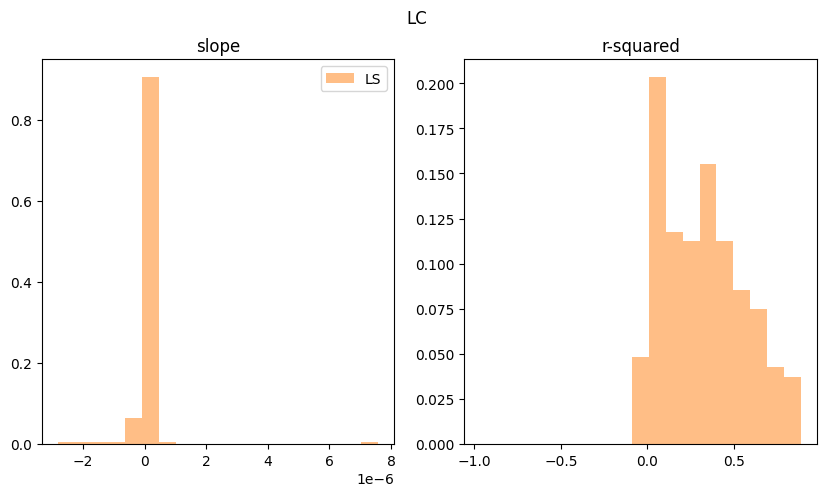

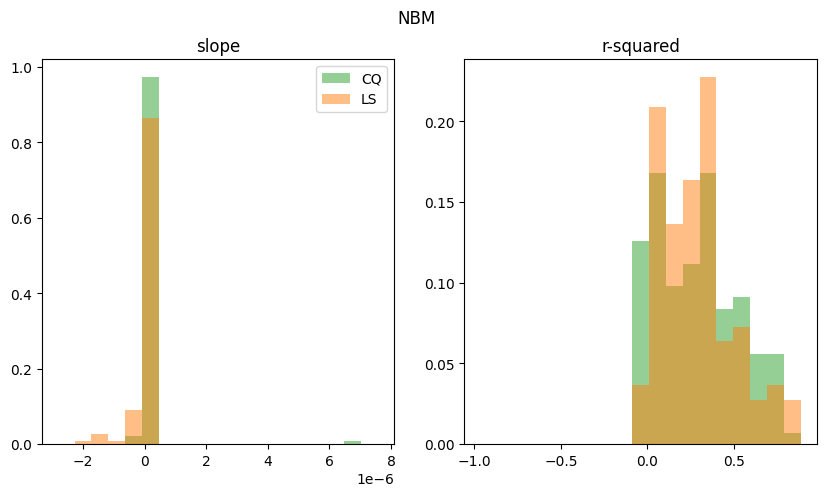

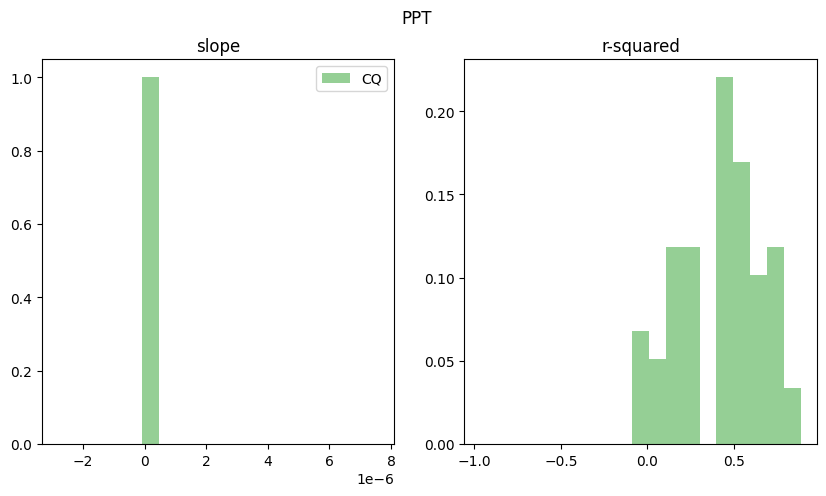

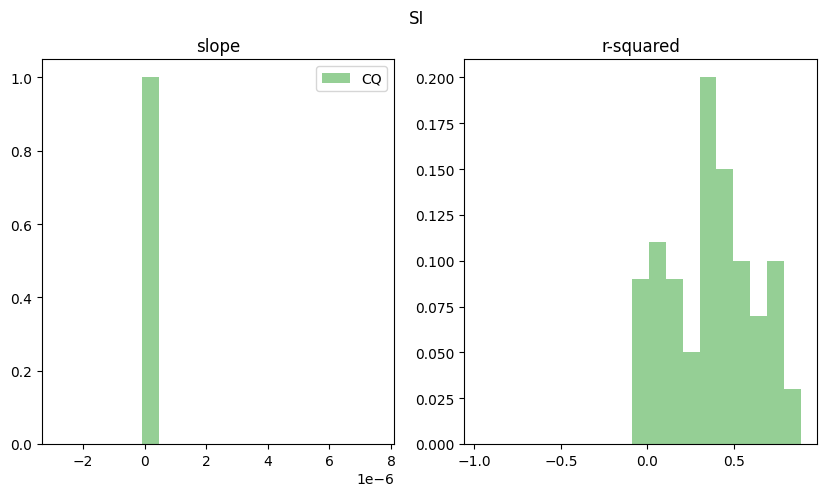

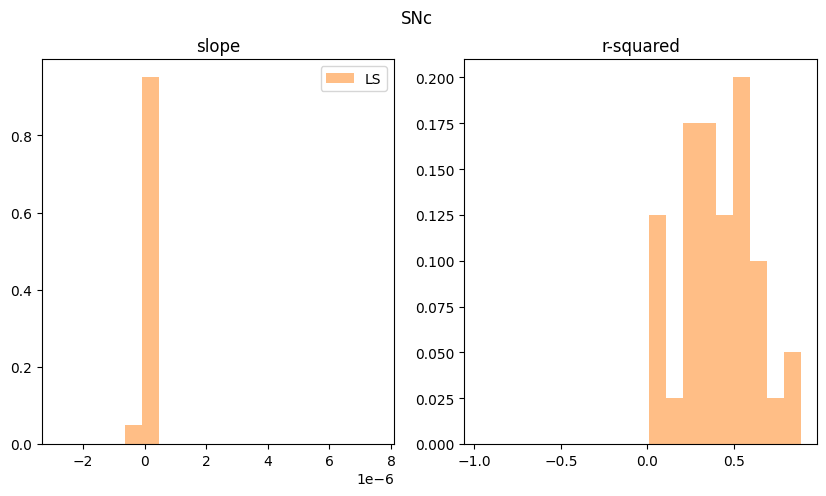

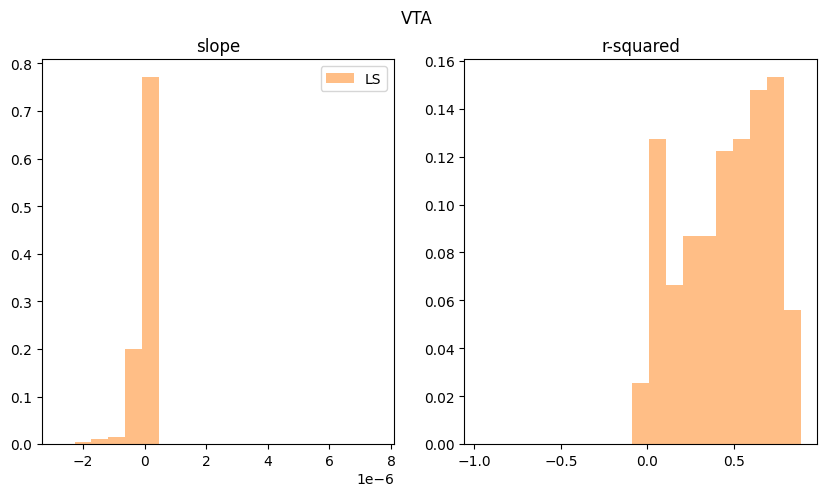

In [130]:
%matplotlib inline
colors = {'KB':'C0', 'LS':'C1', 'CQ':'C2'}
slope_bins = np.linspace(df['slope'].min(), df['slope'].max(), 20)
r_bins = np.linspace(df['r'].min(), df['r'].max(), 20)

for region, region_data in df.groupby('brain_region'):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('slope')
    axs[1].set_title('r-squared')
    fig.suptitle(region)
    for exp, exp_data in region_data.groupby('experimenter'):
        weights = np.ones(len(exp_data)) / len(exp_data)
        axs[0].hist(exp_data['slope'], bins=slope_bins, weights=weights, color=colors[exp], alpha=0.5, label=exp)
        axs[1].hist(exp_data['r'] ** 2, bins=r_bins, weights=weights, color=colors[exp], alpha=0.5)
        axs[0].legend()

## Compare signal quality across coordinates

In [290]:
from one.alf.exceptions import ALFObjectNotFound
from tqdm import tqdm
t_window = 450  # seconds

one = ONE(mode='remote')

df_coords = pd.read_csv('metadata/NBM_coordinates.csv')
# df_coords['coordinate'] = df_coords.apply(lambda x: f"(AP {x['AP']}, ML {np.abs(x['ML'])}, DV {x['DV']})", axis='columns')

sessions = []
for subject in df_coords['subject'].unique():
    sessions.extend(one.alyx.rest('sessions', 'list', project='ibl_fibrephotometry', subject=subject, dataset='photometry.signal.pqt'))
df_sessions = pd.DataFrame(sessions).rename(columns={'id':'eid'})

# Get photometry location data
df_coords = df_coords.set_index(['subject', 'brain_region'])
photometry_sessions = []
no_photometry_sessions = []
for _, session in tqdm(df_sessions.iterrows(), total=len(df_sessions)):
    try:
        # Get fiber locations and ROIs
        df_locations = one.load_dataset(id=session['eid'], dataset='photometryROI.locations.pqt')
    except ALFObjectNotFound:
        no_photometry_sessions.append(session)
        continue
    for roi, location in df_locations.iterrows():
        photometry_session = pd.concat([session, df_coords.loc[session['subject'], location['brain_region']]])
        photometry_session['roi'] = roi
        photometry_sessions.append(photometry_session)

  0%|                                                    | 0/32 [00:00<?, ?it/s]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
  6%|██▊                                         | 2/32 [00:01<00:25,  1.18it/s]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
  9%|████▏                                       | 3/32 [00:02<00:28,  1.01it/s]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
 16%|██████▉                                     | 5/32 [00:05<00:31,  1.16s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
 19%|████████▎              

In [292]:
pd.DataFrame(no_photometry_sessions).to_pickle('CQ_missing_photometry.pkl')

In [294]:
from scipy.stats import linregress

qc_sessions = []
for session in tqdm(photometry_sessions, total=len(photometry_sessions)):
    try:
        df_photometry = one.load_dataset(id=session['eid'], dataset='photometry.signal.pqt')
    except ALFObjectNotFound:
        continue
    
    # Restrict to middle period and convert to a more workable format
    t_mid = df_photometry['times'].median()
    i0 = df_photometry['times'].searchsorted(t_mid - t_window)
    i1 = df_photometry['times'].searchsorted(t_mid + t_window)
    signals = io.from_ibl_dataframe(df_photometry.iloc[i0:i1])
    
    # Pull out gcamp dataframe
    gcamp = signals['GCaMP'][session['roi']]

    # Quick linear detrend
    # coeffs = np.polyfit(gcamp.index, gcamp.values, 1)
    # trend = np.polyval(coeffs, gcamp.index)
    slope, intercept, r_value, p_value, std_err = linregress(gcamp.index, gcamp.values)
    trend = slope * gcamp.index + intercept
    detrended_gcamp = gcamp - trend
    
    session['qc_mean'] = np.mean(gcamp)  # signal mean
    session['qc_slope'] = slope
    session['qc_deviance'] = metrics.median_absolute_deviance(detrended_gcamp)  # median amplitude
    session['qc_percentile_distance'] = metrics.percentile_distance(detrended_gcamp, pc=(50, 95))  # amplitude of positive transients
    session['qc_percentile_asymmetry'] = metrics.percentile_asymmetry(detrended_gcamp, pc_comp=95)  # amplitude of positive versus negative transients
    session['qc_ar_score'] = metrics.ar_score(detrended_gcamp)
    session['qc_spectral_entropy'] = metrics.spectral_entropy(detrended_gcamp)
    qc_sessions.append(session)
df_qc = pd.DataFrame(qc_sessions).dropna()

  0%|                                                    | 0/25 [00:00<?, ?it/s]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
  8%|███▌                                        | 2/25 [00:02<00:26,  1.15s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subject
 16%|███████                

In [297]:
session = df_qc.loc[0]
df_photometry = one.load_dataset(id=session['eid'], dataset='photometry.signal.pqt')
    
# Restrict to middle period and convert to a more workable format
t_mid = df_photometry['times'].median()
i0 = df_photometry['times'].searchsorted(t_mid - t_window)
i1 = df_photometry['times'].searchsorted(t_mid + t_window)
signals = io.from_ibl_dataframe(df_photometry.iloc[i0:i1])

# Pull out gcamp dataframe
gcamp = signals['GCaMP'][session['roi']]

# Quick linear detrend
# coeffs = np.polyfit(gcamp.index, gcamp.values, 1)
# trend = np.polyval(coeffs, gcamp.index)
slope, intercept, r_value, p_value, std_err = linregress(gcamp.index, gcamp.values)
trend = slope * gcamp.index + intercept
detrended_gcamp = gcamp - trend

In [298]:
fig, ax = plt.subplots(figsize=(24, 6))
fig.suptitle('NBM Signal Linear Detrending')
ax.plot(gcamp - gcamp.mean())
ax.plot(detrended_gcamp)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fluorescence (a.u.)')

Text(0, 0.5, 'Fluorescence (a.u.)')

In [300]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM

qc_cols = [col for col in df_qc.columns if 'qc' in col]
xpos = {'original': 0, 'new_1': 1, 'new_2': 2}
colors = {'CQ014': 'C0', 'CQ015': 'C1', 'CQ016': 'C2'}
fig, axs = plt.subplots(1, len(qc_cols), figsize=(len(qc_cols) * 8, 8))
fig.suptitle('NBM Raw Signal Quality Metrics') 
for ax, col in zip(axs, qc_cols):
    print('\n', f'========== {col} ==========')
    
    print('\n', 'ANOVA Results')
    # print('=======================================================================')
    # Simple ANOVA
    model = smf.ols(f'{col} ~ C(label, Treatment("original"))', data=df_qc)
    result = model.fit()
    # Perform ANOVA
    anova_table = sm.stats.anova_lm(result, typ=2)
    print(anova_table)

    # Linear Mixed-effects Model
    model = smf.mixedlm(f'{col} ~ C(label, Treatment("original"))',  # main effects 
                        data=df_qc,
                        groups=df_qc['subject'],  # group by mouse
                        # groups=df_qc['eid'],  # group by session
                        re_formula='~C(label, Treatment("original"))'  # random slopes
                       )
    result = model.fit()
    print(result.summary())
    
    for (coord, subject), data in df_qc.groupby(['label', 'subject']):
        ax.scatter(xpos[coord] + np.random.uniform(-0.15, 0.15, len(data)), data[col], fc='none', ec=colors[subject], lw=2) 
    ax.set_xticks(list(xpos.values()))
    ax.set_xticklabels(list(xpos.keys()))
    ax.set_xlabel('Coordinate')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax.set_ylabel(col)


 ========== qc_mean ==========

 ANOVA Results
                                   sum_sq    df         F    PR(>F)
C(label, Treatment("original"))  0.000013   2.0  5.539826  0.011692
Residual                         0.000024  21.0       NaN       NaN
                                              Mixed Linear Model Regression Results
Model:                                      MixedLM                          Dependent Variable:                          qc_mean 
No. Observations:                           24                               Method:                                      REML    
No. Groups:                                 3                                Scale:                                       0.0000  
Min. group size:                            3                                Log-Likelihood:                              113.4051
Max. group size:                            11                               Converged:                                   No      
Mean grou

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

                                              Mixed Linear Model Regression Results
Model:                                      MixedLM                          Dependent Variable:                          qc_slope
No. Observations:                           24                               Method:                                      REML    
No. Groups:                                 3                                Scale:                                       0.0000  
Min. group size:                            3                                Log-Likelihood:                              263.1282
Max. group size:                            11                               Converged:                                   No      
Mean group size:                            8.0                                                                                   
----------------------------------------------------------------------------------------------------------------------------------

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

                                              Mixed Linear Model Regression Results
Model:                                  MixedLM                     Dependent Variable:                     qc_percentile_distance
No. Observations:                       24                          Method:                                 REML                  
No. Groups:                             3                           Scale:                                  0.4530                
Min. group size:                        3                           Log-Likelihood:                         -25.2990              
Max. group size:                        11                          Converged:                              No                    
Mean group size:                        8.0                                                                                       
----------------------------------------------------------------------------------------------------------------------------------

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

                                            Mixed Linear Model Regression Results
Model:                                    MixedLM                       Dependent Variable:                       qc_ar_score
No. Observations:                         24                            Method:                                   REML       
No. Groups:                               3                             Scale:                                    0.1449     
Min. group size:                          3                             Log-Likelihood:                           -13.4546   
Max. group size:                          11                            Converged:                                No         
Mean group size:                          8.0                                                                                
-----------------------------------------------------------------------------------------------------------------------------
                                    

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.181648
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/

## LED Power

In [394]:
from one.alf.exceptions import ALFObjectNotFound
from tqdm import tqdm
from scipy.stats import linregress
t_window = 0  # seconds

one = ONE(mode='remote')

num2power = {1: 50, 2: 75, 3: 100}

sessions = []
for subject in ['ZFM-08827']:
    sessions.extend(one.alyx.rest('sessions', 'list', project='ibl_fibrephotometry', subject=subject, dataset='photometry.signal.pqt'))
df_sessions = pd.DataFrame(sessions).rename(columns={'id':'eid'})
one.load_dataset(df_sessions.query('task_protocol.str.contains("training")').iloc[0]['eid']

,eid,subject,start_time,number,lab,projects,url,task_protocol
4,0273f66e-11f4-455f-a9ed-9914ede10662,ZFM-08827,2025-09-12T13:43:32.325862,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_trainingChoiceWorld8.29.0
5,dee088ba-2cc1-49b6-9db9-6098c9fb3dae,ZFM-08827,2025-09-11T15:04:38.533711,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_trainingChoiceWorld8.29.0
6,ef1b71a1-0ec9-496c-9bce-df20cf92549a,ZFM-08827,2025-09-10T14:22:41.049102,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_trainingChoiceWorld8.29.0
7,7949e8a8-b244-42b9-861d-426b62845da0,ZFM-08827,2025-09-09T17:44:40.326946,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_trainingChoiceWorld8.29.0
8,ece9bf60-9acf-43d3-b447-4a36546df279,ZFM-08827,2025-09-08T14:02:48.509746,2,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_trainingChoiceWorld8.29.0
...,...,...,...,...,...,...,...,...
63,3ec5f052-4478-4607-ae48-8c099af9a969,ZFM-08827,2025-05-29T12:30:20.790686,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_trainingChoiceWorld8.27.7
64,7186443a-0552-47c8-abe3-4c31dce75a03,ZFM-08827,2025-05-28T17:09:08.223297,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_trainingChoiceWorld8.27.7
65,3cfefc0d-a486-4fe3-a729-aa120cab369c,ZFM-08827,2025-05-22T14:39:53.954049,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_trainingChoiceWorld8.27.6
66,48c1a14e-9085-49ea-b55c-2d5fd51c3585,ZFM-08827,2025-05-21T12:20:53.704194,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_trainingChoiceWorld8.27.6


In [373]:
df_sessions = df_sessions.query('task_protocol.str.contains("passive")')

In [383]:
one.list_datasets(df_sessions.iloc[3]['eid'])

['_ibl_experiment.description.yaml',
 'raw_photometry_data/_mcc_DAQdata.raw.tdms',
 'raw_photometry_data/_neurophotometrics_fpData.raw.pqt',
 'raw_task_data_00/_iblrig_RFMapStim.raw.bin',
 'raw_task_data_00/_iblrig_encoderEvents.raw.ssv',
 'raw_task_data_00/_iblrig_encoderPositions.raw.ssv',
 'raw_task_data_00/_iblrig_encoderTrialInfo.raw.ssv',
 'raw_task_data_00/_iblrig_stimPositionScreen.raw.csv',
 'raw_task_data_00/_iblrig_syncSquareUpdate.raw.csv',
 'raw_task_data_00/_iblrig_taskSettings.raw.json',
 'raw_video_data/_iblrig_leftCamera.frameData.bin',
 'raw_video_data/_iblrig_leftCamera.raw.mp4']

In [392]:
df_sessions.iloc[:3]

,eid,subject,start_time,number,lab,projects,url,task_protocol
0,8e90c792-7b07-44c5-82bb-cff827c1a246,ZFM-08827,2025-09-30T15:19:29.934377,3,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_passiveChoiceWorld8.29.0
1,c12b7c08-d1c8-45b4-865c-a6289d16fb40,ZFM-08827,2025-09-30T14:57:13.589909,2,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_passiveChoiceWorld8.29.0
2,e782752d-eafa-42e2-9b53-b89375fe2186,ZFM-08827,2025-09-30T14:32:55.867748,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_passiveChoiceWorld8.29.0


In [406]:
# Get photometry location data
photometry_sessions = []
no_photometry_sessions = []
qc_sessions = []
for _, session in tqdm(df_sessions.iloc[:3].iterrows(), total=3):
    df_photometry = one.load_dataset(id=session['eid'], dataset='raw_photometry_data/_neurophotometrics_fpData.raw.pqt')
    gcamp = df_photometry.query('LedState == 2')['G2']
    session['qc_mean'] = np.mean(gcamp)  # signal mean
    session['qc_deviance'] = metrics.median_absolute_deviance(gcamp)  # median amplitude
    session['qc_percentile_distance'] = metrics.percentile_distance(gcamp, pc=(50, 95))  # amplitude of positive transients
    session['qc_percentile_asymmetry'] = metrics.percentile_asymmetry(gcamp, pc_comp=95)  # amplitude of positive versus negative transients
    session['qc_ar_score'] = metrics.ar_score(gcamp)
    session['qc_spectral_entropy'] = metrics.spectral_entropy(gcamp)
    qc_sessions.append(session)
df_qc = pd.DataFrame(qc_sessions).dropna()

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.08it/s]


In [407]:
df_qc

,eid,subject,start_time,number,lab,projects,url,task_protocol,qc_mean,qc_deviance,qc_percentile_distance,qc_percentile_asymmetry,qc_ar_score,qc_spectral_entropy
0,8e90c792-7b07-44c5-82bb-cff827c1a246,ZFM-08827,2025-09-30T15:19:29.934377,3,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_passiveChoiceWorld8.29.0,0.007092,0.000062,1.810767,1.323741,0.837830,0.364014
1,c12b7c08-d1c8-45b4-865c-a6289d16fb40,ZFM-08827,2025-09-30T14:57:13.589909,2,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_passiveChoiceWorld8.29.0,0.010606,0.000175,1.892996,1.371930,0.953904,0.528975
2,e782752d-eafa-42e2-9b53-b89375fe2186,ZFM-08827,2025-09-30T14:32:55.867748,1,mainenlab,[ibl_fibrephotometry],https://alyx.internationalbrainlab.org/session...,_iblrig_tasks_passiveChoiceWorld8.29.0,0.014205,0.000576,2.298329,3.255940,0.996516,0.686189


In [411]:
qc_cols = [col for col in df_qc.columns if 'qc' in col]
xpos = {1: 0, 2: 1, 3: 2}
power = {1: 50, 2: 75, 3: 100}
fig, axs = plt.subplots(1, len(qc_cols), figsize=(len(qc_cols) * 8, 8))
# fig.suptitle('NBM Raw Signal Quality Metrics') 
for ax, col in zip(axs, qc_cols):
    for number, data in df_qc.groupby('number'):
        ax.scatter(xpos[number] + np.random.uniform(-0.15, 0.15, len(data)), data[col], fc='none', ec='black', lw=2) 
    ax.set_xlabel('Power level')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax.set_ylabel(col)